In [3]:
# -*- coding: utf-8 -*-
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import PIL.Image as Image

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
           
class CBR(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        norm_layer = nn.BatchNorm2d
        super(CBR, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            norm_layer(out_planes),
            nn.ReLU(inplace=True),
        )
class CBLR(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        norm_layer = nn.BatchNorm2d
        super(CBLR, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            norm_layer(out_planes),
            nn.ReLU(inplace=True),
        )
class TCBR(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=4, stride=2, padding=1):
        padding = (kernel_size - 1) // 2
        norm_layer = nn.BatchNorm2d
        super(TCBR, self).__init__(
            nn.ConvTranspose2d(in_planes, out_planes, kernel_size, stride, padding, bias=False),
            norm_layer(out_planes),
            nn.ReLU(inplace=True),
        )                    
                                                 
class Generator(nn.Module):
    def __init__(self, latents):
        super(Generator, self).__init__()
        
        self.layer1= nn.Sequential(
            # input is random_Z,  state size. latents x 1 x 1 
            # going into a convolution
            TCBR(latents, 256, 4, 2, 1),  # state size. 256 x 2 x 2
            CBR(256, 128, 3, 1)
        )
        
        self.layer2= nn.Sequential(
            TCBR(128, 256, 4, 1, 0), # state size. 256 x 3 x 3
            TCBR(256, 256, 4, 2, 1), # state size. 256 x 6 x 6
            
        )
        self.layer3= nn.Sequential(
            TCBR(256, 128, 4, 1, 0), # state size. 256 x 7 x 7
            TCBR(128, 128, 4, 2, 1),  # state size. 256 x 14 x 14
            CBR(128, 128, 3, 1)
            # state size. 256 x 6 x 6

        )
        self.layer4= nn.Sequential(
            TCBR(128, 64, 4, 2, 1), # state size. 64 x 28 x 28
            CBR(64, 64, 3, 1),
            CBR(64, 64, 3, 1),
            nn.Conv2d(64, 1, 3, 1, 1), # state size. 1 x 28 x 28
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x
    

class Discriminator(nn.Module):
    def __init__(self,):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            CBLR(1, 32, 3, 2), # b*32*14*14
            CBLR(32, 64, 3, 1), # b*64*14*14
            CBLR(64, 128, 3, 2), # b*128*7*7
            CBLR(128, 128, 3, 2), # b*32*3*3
            CBLR(128, 64, 3, 2), # b*32*1*1
        )        
        self.fc = nn.Linear(64,2)

    def forward(self, x):
        x = self.conv(x)
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        ft = x
        output = self.fc(x)
        return output

In [15]:
# from torchvision.utils import save_image

flag_gpu = 1
# Number of workers for dataloader
workers = 0
# Batch size during training
batch_size = 100
# Number of training epochs
epochs = 5
# Learning rate for optimizers
lr = 0.0002

# GPU
device = 'cuda:0' if (torch.cuda.is_available() & flag_gpu) else 'cpu'
print('GPU State:', device)
# Model
latent_dim = 10
G = Generator(latents=latent_dim).to(device)
D = Discriminator().to(device)
G.apply(weights_init)
D.apply(weights_init)

# Settings
g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

g_scheduler = torch.optim.lr_scheduler.StepLR(g_optimizer, step_size=5, gamma=0.5)
d_scheduler = torch.optim.lr_scheduler.StepLR(d_optimizer, step_size=5, gamma=0.5)

# Load data
train_set = datasets.MNIST('./dataset', train=True, download= True, transform=transforms.ToTensor())
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=workers)

GPU State: cpu


epoch 1
[Epoch: 1/5] D_loss: 0.338 G_loss: 1.431
Generated images for epoch: 1


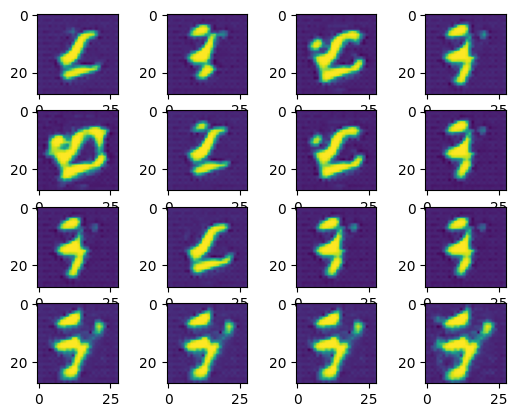

epoch 2
[Epoch: 2/5] D_loss: 0.290 G_loss: 1.577
Generated images for epoch: 2


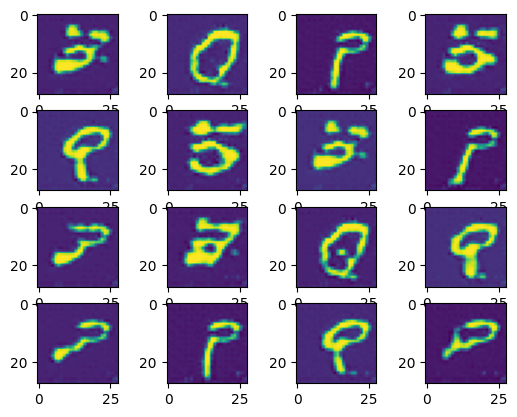

epoch 3
[Epoch: 3/5] D_loss: 0.417 G_loss: 1.204
Generated images for epoch: 3


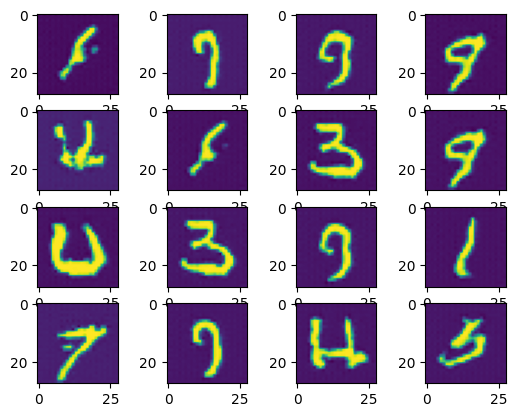

epoch 4
[Epoch: 4/5] D_loss: 0.433 G_loss: 1.156
Generated images for epoch: 4


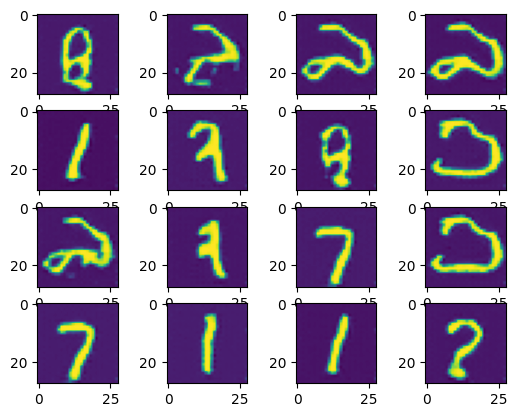

epoch 5
[Epoch: 5/5] D_loss: 0.473 G_loss: 1.089
Generated images for epoch: 5


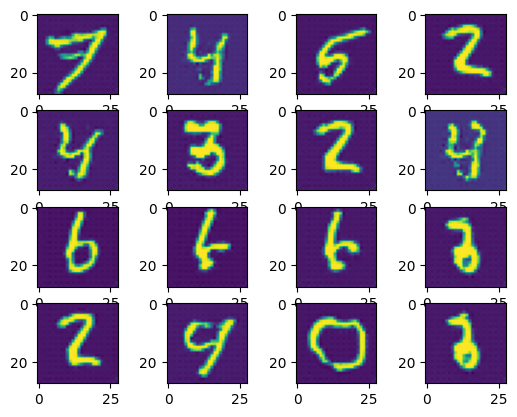

Model saved.
Training Finished.
Cost Time: 2648.3248286247253s


In [16]:
def show_images(images, epoch):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    plt.figure()
    for index, image in enumerate(images):
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.imshow(image.reshape(28, 28))
    plt.savefig("Generator_epoch_{}.png".format(epoch))
# Train
adversarial_loss = torch.nn.CrossEntropyLoss().to(device)
# adversarial_loss = torch.nn.BCELoss().to(device)

G.train()
D.train()
loss_g, loss_d = [],[]
start_time= time.time()
for epoch in range(epochs):
    epoch += 1
    total_loss_g,total_loss_d=0,0
    count_d=0
    print("epoch", epoch)
    for i_iter, (images, label) in enumerate(train_loader):
        i_iter += 1
    
        # -----------------
        #  Train Generator
        # -----------------
        g_optimizer.zero_grad()
        # Sample noise as generator input
        noise = torch.randn(images.shape[0], latent_dim, 1, 1)
        noise = noise.to(device)
        
        # 因為Generator希望生成出來的圖片跟真的一樣，所以fake_label標註用 1
        fake_label = torch.ones(images.shape[0], dtype=torch.long).to(device) # notice: label = 1

        # Generate a batch of images
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        
        # Loss measures generator's ability to fool the discriminator
        loss_g_value = adversarial_loss(fake_outputs, fake_label)
        loss_g_value.backward()
        g_optimizer.step()
        total_loss_g+=loss_g_value
        loss_g.append(loss_g_value) 
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        # Zero the parameter gradients
        d_optimizer.zero_grad()
        # Measure discriminator's ability to classify real from generated samples
        # 因為Discriminator希望判斷哪些是真的那些是生成的，所以real_label資料標註用 1，fake_label標註用0。
        real_inputs = images.to(device) 
        real_label = torch.ones(real_inputs.shape[0], dtype=torch.long).to(device)
        fake_label = torch.zeros(fake_inputs.shape[0], dtype=torch.long).to(device)
#       learning by Discriminator
        real_loss = adversarial_loss(D(real_inputs),real_label)
        fake_loss = adversarial_loss(D(fake_inputs.detach()),fake_label)
        loss_d_value = (real_loss + fake_loss) / 2
        loss_d_value.backward()
        d_optimizer.step()
        total_loss_d+=loss_d_value
        loss_d.append(loss_d_value)  
        
    total_loss_g/=len(train_loader)
    total_loss_d/=len(train_loader)         
    g_scheduler.step()
    d_scheduler.step()
    print('[Epoch: {}/{}] D_loss: {:.3f} G_loss: {:.3f}'.format(epoch, epochs, total_loss_d.item(), total_loss_g.item()))
    if epoch % 1 == 0:
        print('Generated images for epoch: {}'.format(epoch))
        imgs_numpy = fake_inputs.data.cpu().numpy()
        show_images(imgs_numpy[:16],epoch)
        plt.show()

torch.save(G, 'DCGAN_Generator.pth')
torch.save(D, 'DCGAN_Discriminator.pth')
print('Model saved.')

print('Training Finished.')
print('Cost Time: {}s'.format(time.time()-start_time))

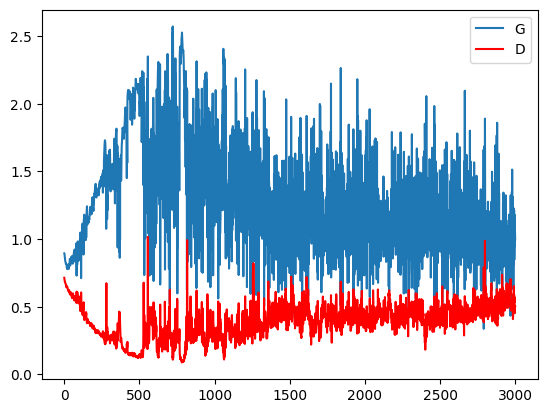

In [22]:
# 使用 detach() 創建不再需要梯度的張量，然後轉換為 NumPy array
loss_g_numpy = [tensor.detach().numpy() for tensor in loss_g]
loss_d_numpy = [tensor.detach().numpy() for tensor in loss_d]

plt.plot(loss_g_numpy)
plt.plot(loss_d_numpy,'r')
plt.legend(['G','D'])
plt.show()